In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers, Model
import tensorflow as tf

In [93]:
# Load the segmented data
file_path = r"C:\Users\ADWIN ADI\Downloads\MainData_10sec_Segmented.csv"  # Replace with your local path if needed
df = pd.read_csv(file_path)

# Preview
df.head()

,Sensor1_Temp,Sensor1_Pressure,Sensor1_Humidity,Sensor2_Temp,Sensor2_Pressure,Sensor2_Humidity,segment_id,Label
0,0.06,0.0263,0.01,0.05,0.0338,0.0,0,N
1,0.05,0.0261,0.01,0.04,0.0440,0.0,0,N
2,0.04,0.0221,0.19,0.03,0.0562,0.0,0,N
3,0.04,0.0119,0.32,0.03,0.0457,0.0,0,N
4,0.04,0.0117,0.38,0.03,0.0344,0.0,0,N


In [94]:
# Define feature columns
feature_columns = [
    'Sensor1_Temp', 'Sensor1_Pressure', 'Sensor1_Humidity',
    'Sensor2_Temp', 'Sensor2_Pressure', 'Sensor2_Humidity'
]

# Segment-wise grouping
segments = df['segment_id'].unique()

# Stack segments into 3D shape: (segments, timesteps, features)
X = np.stack([
    df[df['segment_id'] == seg][feature_columns].values
    for seg in segments
])

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df.groupby('segment_id')['Label'].first().values)

In [95]:
# Normalize the features

scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)

print("X shape:", X_scaled.shape)
print("y shape:", y.shape)

X shape: (733, 150, 6)
y shape: (733,)


In [96]:
class BreathingAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(BreathingAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(BreathingAttention, self).build(input_shape)

    def call(self, inputs):
        e = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=1)
        context = tf.reduce_sum(inputs * alpha, axis=1)
        return context

In [97]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    return x + res

In [104]:
input_layer = layers.Input(shape=(150, 6))

# 1D CNN for feature extraction
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(input_layer)
x = layers.MaxPooling1D(pool_size=2)(x)

# Bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

# Transformer block
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

# Custom attention
attention_output = BreathingAttention()(x)

# Dense & Dropout
x = layers.Dense(64, activation='relu')(attention_output)
x = layers.Dropout(0.3)(x)

# Output layer
output_layer = layers.Dense(3, activation='softmax')(x)

# Final model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 150, 6)]     0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 150, 64)      1984        ['input_10[0][0]']               
                                                                                                  
 max_pooling1d_11 (MaxPooling1D  (None, 75, 64)      0           ['conv1d_11[0][0]']              
 )                                                                                                
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 75, 128)     66048       ['max_pooling1d_11[0][0]'] 

In [105]:
# Split into train and test (you can use sklearn's train_test_split)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=30, batch_size=16)

Epoch 1/30
37/37 [==============================] - 9s 114ms/step - loss: 0.8644 - accuracy: 0.6536 - val_loss: 0.5429 - val_accuracy: 0.7959
Epoch 2/30
37/37 [==============================] - 3s 85ms/step - loss: 0.6334 - accuracy: 0.7235 - val_loss: 0.4585 - val_accuracy: 0.8503
Epoch 3/30
37/37 [==============================] - 3s 86ms/step - loss: 0.5033 - accuracy: 0.8072 - val_loss: 0.3999 - val_accuracy: 0.8163
Epoch 4/30
37/37 [==============================] - 3s 85ms/step - loss: 0.4292 - accuracy: 0.8276 - val_loss: 0.5254 - val_accuracy: 0.7755
Epoch 5/30
37/37 [==============================] - 3s 94ms/step - loss: 0.3799 - accuracy: 0.8464 - val_loss: 0.3217 - val_accuracy: 0.8980
Epoch 6/30
37/37 [==============================] - 3s 86ms/step - loss: 0.2937 - accuracy: 0.8959 - val_loss: 0.2809 - val_accuracy: 0.8912
Epoch 7/30
37/37 [==============================] - 3s 85ms/step - loss: 0.3168 - accuracy: 0.8584 - val_loss: 0.3517 - val_accuracy: 0.8163
Epoch 8/30
3

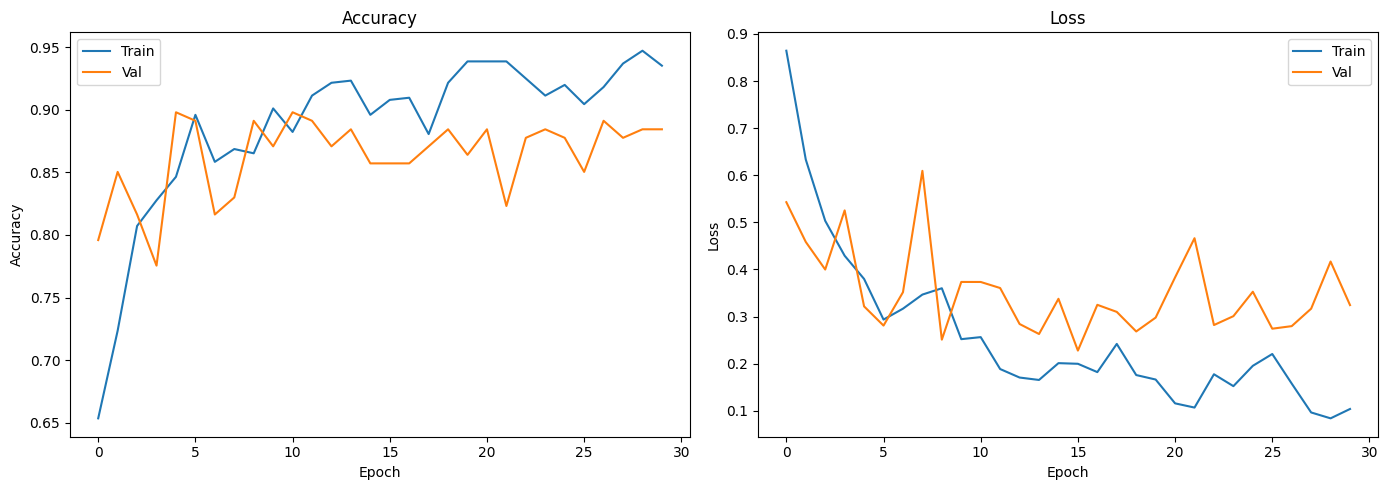

In [106]:
import matplotlib.pyplot as plt

# Accuracy and Loss Plot
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/30
37/37 [==============================] - 9s 81ms/step - loss: 1.0133 - accuracy: 0.5683 - val_loss: 0.8727 - val_accuracy: 0.6599
Epoch 2/30
37/37 [==============================] - 2s 64ms/step - loss: 0.7448 - accuracy: 0.6860 - val_loss: 0.5459 - val_accuracy: 0.7551
Epoch 3/30
37/37 [==============================] - 3s 71ms/step - loss: 0.6137 - accuracy: 0.7304 - val_loss: 0.5076 - val_accuracy: 0.7959
Epoch 4/30
37/37 [==============================] - 3s 75ms/step - loss: 0.7039 - accuracy: 0.7321 - val_loss: 0.6359 - val_accuracy: 0.7687
Epoch 5/30
37/37 [==============================] - 3s 73ms/step - loss: 0.6813 - accuracy: 0.7116 - val_loss: 0.6437 - val_accuracy: 0.7551
Epoch 6/30
37/37 [==============================] - 3s 79ms/step - loss: 0.7197 - accuracy: 0.7270 - val_loss: 0.5709 - val_accuracy: 0.8231
Epoch 7/30
37/37 [==============================] - 3s 80ms/step - loss: 0.7516 - accuracy: 0.7218 - val_loss: 0.8437 - val_accuracy: 0.6803
Epoch 8/30
37

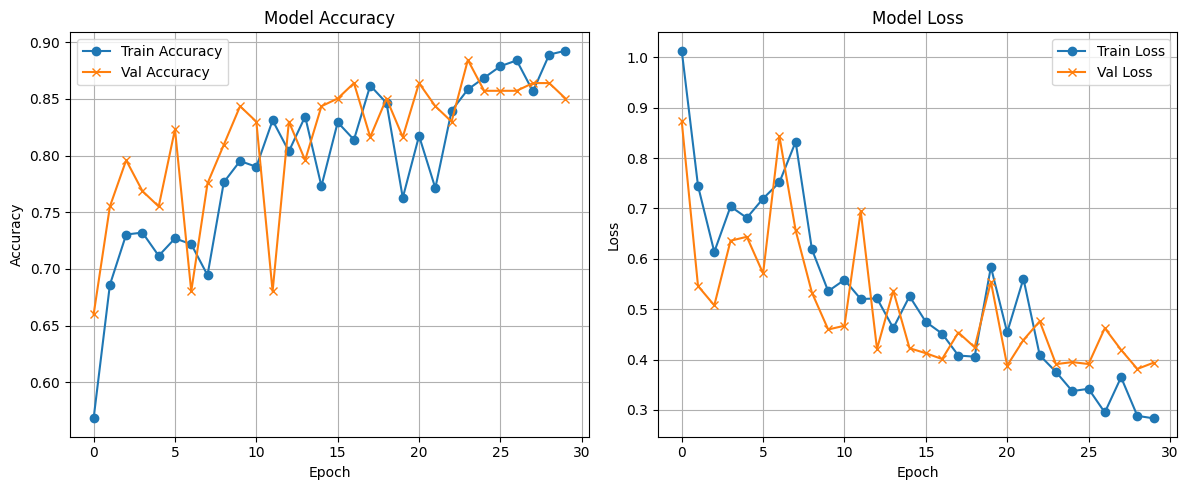

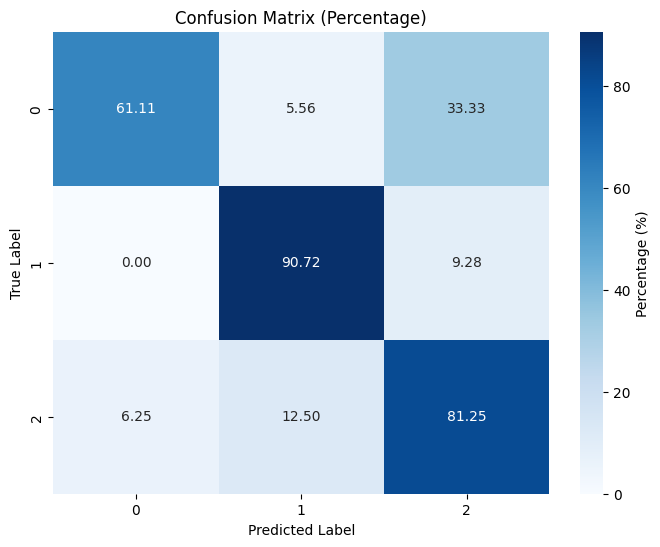

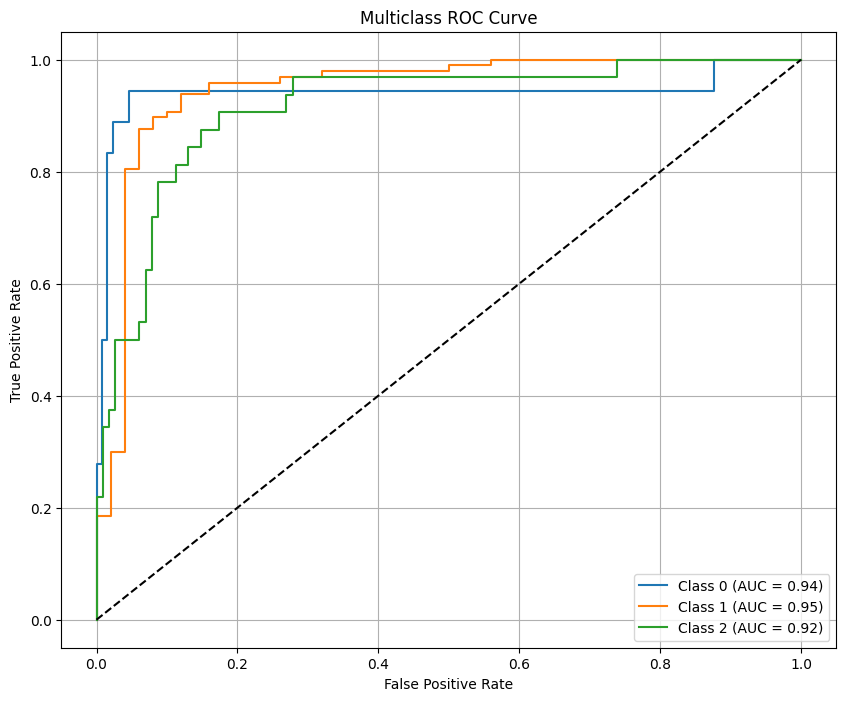

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# === Step 1: Encode Labels ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y must be a 1D array of labels
y_categorical = to_categorical(y_encoded)   # One-hot encoding for multiclass classification

# === Step 2: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# === Step 3: Define Model (Adjust input_shape as per your X shape) ===
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Step 4: Train Model ===
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=16)

# === Step 5: Plot Accuracy & Loss ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Step 6: Predict & Evaluate ===
y_pred_proba = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix (in %)
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
class_names = label_encoder.classes_

# === Step 7: Plot Confusion Matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.show()

# === Step 8: Plot ROC Curve for Each Class ===
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
